# 1. Kernel Ridge Regression

\begin{align*}
\text{Primal form:}~&\Vert Ax - y \Vert_2^2 + \lambda \Vert x \Vert_2^2\\
\textbf{Closed-form solution:}~&x = \left(A^TA + \lambda I_n\right)^{-1}A^Ty\\
\end{align*}

From the identity $\left(A^TA + \lambda I_n\right)^{-1}A^T = A^T\left(AA^T + \lambda I_m\right)^{-1}$, we can obtain a closed-form solution with the alternate form:
\begin{align*}
\textbf{Alternate closed-form solution:}~x = A^T\left(AA^T + \lambda I_m\right)^{-1}y
\end{align*}

Let $A$ have $m$ rows and $n$ columns, such that each row is a data-point (or sample) and each column is a feature. In typical applications of kernel ridge regression, $m >> n$. This means that computing $\alpha$ directly requires computing the $m \times m$ matrix, $AA^T$. For very large $m$ this can be an expensive $m^2n$ operation and, in the extreme, we many not even have space to store $AA^T$.

The Kernelized variant of ridge regression replaces the $m \times n$ matrix $A$ with a high-dimensional feature space for each sample $\Phi(A)$. $\Phi(A)$ is computational-expensive to form, especially when the chosen kernel function has infinite-dimensional feature space (e.g. Radial Basis Function). However, the $m \times m$ kernel matrix $K$ can be computed since the kernel functions are defined by $K_{i,j} = \sum k(a_i, a_j)$, where $a_i$ is the $i$-th row of $A$ and $k(...)$ is a user-defined kernel function.

One example of such a kernel function, is the polynomial kernel: $k(a_i, a_j) = (a_ia_j^T + r)^d$ s.t. $r \geq 0$ and $d \geq 1$. *When $r = 0$ and $d = 1$, we obtain a simple dot-product (or linear kernel).* In replacing the dot-products with a kernel function, we obtain a feature-space that can have very high dimensions (possibly infinite-dimensions). This means that computing the solution, $x$, is often very expensive. So instead, we will focus on obtaining the solution:
\begin{align*}
\bf
\text{Alternate solution:}~&\alpha = \left(\frac{1}{\lambda}K + I_m\right)^{-1}y\\
\text{and}~&w = \frac{1}{\lambda}\Phi(A)^T\alpha
\end{align*}

# 2. Subspace Iteration for Kernel Ridge Regression

Note that the kernel matrix, $K$, is more expensive to compute than $AA^T$ (due to the kernel function), so we will instead compute the solution to $\alpha$ iteratively using ***subspace iteration*** by selecting, and solving for a few samples (row of $A$) every iteration.
\begin{align*}
\text{Dual form:}~&\Vert \alpha - y \Vert_2^2 + \frac{1}{\lambda} \Vert \Phi(A)^T\alpha \Vert_2^2\\

\bf\text{Iterative update:}~&\alpha_h = \alpha_{h-1} + \mathbb{I}_h^T {u_h}\\
\end{align*}
The matrix $\mathbb{I}_h$ has $b$ rows and $m$ columns such that rows of $\mathbb{I}_h$ are sub-sampled rows of the $m$-dimensional identity matrix, $I_m$.

By substituting the iterative update into the dual form, we obtain the following minimization problem:
\begin{align*}
{\arg\min}~\left\Vert \alpha_{h-1} + \mathbb{I}_h^Tu_h - y \right\Vert_2^2 + \frac{1}{\lambda} \left\Vert \Phi(A)^T\alpha_{h-1} + \Phi(A)^T\mathbb{I}_h^T u_h\right\Vert_2^2
\end{align*}

By taking the derivative w.r.t $u_h$ we can obtain the gradient for just the $b$ rows of $A$ that we are sampling at every iteration:
\begin{align*}
0 &= \mathbb{I}_h\alpha_{h-1} + u_h - \mathbb{I}_hy + \frac{1}{\lambda} \mathbb{I}_h \Phi(A)\Phi(A)^T\alpha_{h-1} + \frac{1}{\lambda}\mathbb{I}_h\Phi(A)\Phi(A)^T\mathbb{I}_h^T u_h\\
 \textbf{Gradient w.r.t chosen samples: }u_h &= \left(\frac{1}{\lambda} \mathbb{I}_h\Phi(A)\Phi(A)^T\mathbb{I}_h^T + I_b \right)^{-1}\left(\mathbb{I}_h y - \mathbb{I}_h \alpha_{h-1} - \frac{1}{\lambda}\mathbb{I}_h \Phi(A)\Phi(A)^T\alpha_{h-1}\right)
\end{align*}

Notice that the term $\mathbb{I}_h \Phi(A)\Phi(A)^T \alpha_{h-1}$ does not permit the use of an auxiliary vector to represent $\Phi(A)^T \alpha_{h-1}$ due to the kernelization. This means that we will have to explicitly compute $\mathbb{I}_h\Phi(A)\Phi(A)^T$ at every iteration. Additionally, the quantity $\mathbb{I}_h\Phi(A)\Phi(A)^T\mathbb{I}_h^T$ does not need to be computed at every iteration because we can simply select the relevant columns (namely the columns defined by right-multiplying by $\mathbb{I}_h^T)$ from the quantity $\mathbb{I}_h\Phi(A)\Phi(A)^T$.

In [1]:
import numpy as np
import scipy as sp
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt


class Kernel_Ridge_Regression(object):
    def __init__(self, data, labels, kernel_params={'kernel_type': 'gaussian', 'sigma': 1e-1}):
        self.kernel_params = kernel_params
        self.nsamples, self.nfeatures = data.shape
        if self.nsamples != len(labels):
            raise ValueError('len(labels) != data.shape[1].')
        self.data = data
        self.labels = labels
        self._set_kernel_function(kernel_params['kernel_type'])
        self.alpha = np.zeros(self.nsamples)

    def _set_kernel_function(self, kernel_type):
        kernel_type = kernel_type.lower()
        if kernel_type == 'gaussian':
             self.kernel_function = self._gaussian_kernel
        elif kernel_type == 'polynomial':
            self.kernel_function = self._polynomial_kernel
        else:
            raise ValueError("Invalid kernel choice: {}".format(kernel_type))
    
    def _gaussian_kernel(self, subsamples, samples):
        kernel_matrix = pairwise_distances(subsamples, samples, metric='euclidean')**2
        kernel_matrix = np.exp(-kernel_matrix/self.kernel_params['sigma']**2)
        return kernel_matrix
    
    def _polynomial_kernel(self, subsamples, samples):
        kernel_matrix = (subsamples.dot(samples.T) + self.kernel_params['shift']) ** self.kernel_params['dim']
        return kernel_matrix
    
    def compute_objective(self):
        obj_val = np.linalg.norm(self.alpha - self.labels)**2
        obj_val += 1/self.C * (self.alpha.T.dot(self.kernel_function(self.data, self.data).dot(self.alpha)))
        return obj_val
    
    def block_coordinate_descent(self, idxs):
        blkrow_kernel_matrix = self.kernel_function(self.data[idxs, :], self.data)
        residual = self.labels[idxs] - self.alpha[idxs] - (1/self.C)*blkrow_kernel_matrix.dot(self.alpha)
        blkdiag_kernel_matrix = ((1/self.C) * blkrow_kernel_matrix[:, idxs]) + 1
        blk_gradient = np.linalg.solve(blkdiag_kernel_matrix, residual)
        self.alpha[idxs] += blk_gradient

    def commavoid_block_coordinate_descent(self, idxs):
        raise NotImplementedError()

    def train(self, epochs=100, optimizer='bcd', optimizer_params={'C': 1e-4, 'block_size': 64, 'shuffle': False}):
        if optimizer.lower() == 'bcd':
            optimizer = self.block_coordinate_descent
        elif optimizer.lower() == 'cabcd':
            optimizer = self.commavoid_block_coordinate_descent
            self.s = optimizer_params['s']
        else:
            raise ValueError('Invalid optimizer choice: {}'.format(optimizer))
        self.C = optimizer_params['C']
        self.block_size = optimizer_params['block_size']
        self.shuffle = optimizer_params['shuffle']
        loss_history = []
        for epoch in range(1,epochs+1):
            if self.shuffle: 
                idxs = np.random.choice(self.nsamples, size=self.nsamples, replace=False)
            else:
                idxs = np.arange(self.nsamples)
            nblocks = len(idxs)/self.block_size
            for block in np.array_split(idxs, nblocks):
                if len(block) < 1:
                    break
                optimizer(block)
            loss_history.append(self.compute_objective())

            print('[{}] loss {}.'.format(epoch, loss_history[-1]))
        plt.plot(loss_history)

    def test(self):
        raise NotImplementedError()


[1] loss 455575.84774228814.
[2] loss 455568.94588346436.
[3] loss 455563.36309322156.
[4] loss 455558.49270357314.
[5] loss 455554.10903142026.
[6] loss 455550.0899671926.
[7] loss 455546.35799600225.
[8] loss 455542.85959308106.
[9] loss 455539.5559578991.
[10] loss 455536.4180079224.
[11] loss 455533.42335874704.
[12] loss 455530.5543854704.
[13] loss 455527.796931421.
[14] loss 455525.139424938.
[15] loss 455522.5722613139.
[16] loss 455520.08736097417.
[17] loss 455517.67784715287.
[18] loss 455515.33780618815.
[19] loss 455513.06210603664.
[20] loss 455510.84625658713.
[21] loss 455508.6863005324.
[22] loss 455506.5787269625.
[23] loss 455504.52040212415.
[24] loss 455502.5085133443.
[25] loss 455500.54052317847.
[26] loss 455498.61413160205.
[27] loss 455496.72724459774.
[28] loss 455494.87794787233.
[29] loss 455493.06448473386.
[30] loss 455491.2852373601.
[31] loss 455489.5387108572.
[32] loss 455487.8235196232.
[33] loss 455486.13837563514.
[34] loss 455484.4820783376.
[35] 

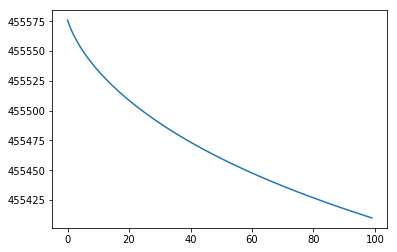

In [3]:
from sklearn.datasets import load_svmlight_file

(data, labels) = load_svmlight_file('../data/abalone')
krr = Kernel_Ridge_Regression(data, labels)
krr.train(epochs=100)